# Physics Informed Neural Network
Tengamos una ecuacion diferencial que guia un fenomeno

$$
\frac{d^2}{dt^2} \psi = F(\psi, t)
$$

donde se tiene una condicion de borde

$$
\psi(t=0) = \psi_0
$$

puede referirse a un campo electrico o una funcion de onda de mecanica cuantica;

En una red informada con fisica le informamos sobre las ecuaciones que deben cumplirse;
osea estas pasan a ser reglas, por ejemplo funciones de perdida

$$
\mathcal L_{DE} = \frac{1}{M} \sum_j^M \{ \frac{d^2}{dt^2} \psi_j - F(\psi_j, t_j) \}^2
$$

y las condiciones de borde:
$$
\mathcal L_{BC} = \{ \psi(t=0) - \psi_0 \}^2
$$

entonces la funcion de perdida final viene dada por:
$$
\mathcal L = \mathcal L_{DE} + \mathcal L_{BC}
$$

In [5]:
# Ecuacion Diferencial
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat

import functools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def grad(outputs, inputs):
    """Computa las derivadas parciles de output respecto a inputs
    aprovechando la autoderivacion
    Arguments:
    - outputs: (N, 1) tensor
    - inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )


def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T

La ecuación diferencial
$$
\frac{dT}{dt} = - R (T - T_{env})
$$

resolviendola analiticamente para asi generar datos (es posible generarlos con meotodos numericos pero eso alargaria este ejemplo pedagogico):
$$
\int \frac{dT}{T - T_{env}} = \int - R dt
$$

$$
T[t] = C e^{-R t} + T_{env}
$$

En el tiempo $t=0$ debemos de recuperar la temperatura inicial $T_0$

$$
T[t] = (T_0 - T_{env}) e^{-R t} + T_{env}
$$

Cooling_Law es la ley de enfriamiento ya resuelta:
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)



In [20]:
# donde se ubica la información de tensores
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def np_to_torch_tensor(x):
    """ convierte un arreglo en un tensor plano """
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)


class Net(nn.Module):
    def __init__( self,
        input_dim, output_dim, n_units=100, epochs=1000,
        loss=nn.MSELoss(), lr=1e-3, loss2=None, loss2_weight=0.1) -> None:

        super().__init__() # inicializa como nn.Modulo su clase padre

        # parametros utiles dentro de la red
        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        # Layers compuestas por ReLU simples
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim) # una capa que combine todo

    def forward(self, x): # metodo de forward simple
        h = self.layers(x)
        out = self.out(h)
        return out

    def fit(self, X, y): # fitting function
        Xt = np_to_torch_tensor(X)
        yt = np_to_torch_tensor(y)

        # se utiliza el optimizador Adam
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        self.train() # se activa el modo de entrenamiento
        losses = [] # array de loss's

        for ep in range(self.epochs):
            optimizer.zero_grad() 
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2: # funcion de perdida extra
                loss += self.loss2_weight * self.loss2(self)
            
            loss.backward()  # recorre el grafico y obtiene derivadas parciales
            optimizer.step()  # usa la información para actualizar parametros

            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")

        return losses

    def predict(self, X):
        self.eval() # modo de evaluación no genera graficos de pasos en torch
        out = self.forward(np_to_torch_tensor(X))
        return out.detach().cpu().numpy()


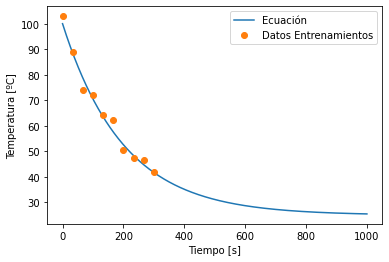

In [12]:
# Parametros fisicos
Tenv = 25
T0 = 100
R = 0.005

# Ecuación 
times = np.linspace(0, 1000, 1000)
temps = cooling_law(times, Tenv, T0, R)

# Datos de Entrenamiento
t = np.linspace(0, 300, 10)
T = cooling_law(t, Tenv, T0, R) +  2 * np.random.randn(10)

# Plotting
plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Ecuación', 'Datos Entrenamientos'])
plt.ylabel('Temperatura [ºC]')
plt.xlabel('Tiempo [s]')
plt.show()

# Red Clasica
El funcionamiento de una red sin haber implementado una función de perdida extra

Epoch 0/10000, loss: 4876.25
Epoch 1000/10000, loss: 2533.46
Epoch 2000/10000, loss: 2454.10
Epoch 3000/10000, loss: 2240.89
Epoch 4000/10000, loss: 1774.33
Epoch 5000/10000, loss: 998.54
Epoch 6000/10000, loss: 266.84
Epoch 7000/10000, loss: 24.05
Epoch 8000/10000, loss: 7.00
Epoch 9000/10000, loss: 5.73


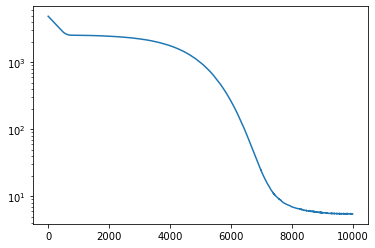

In [17]:
# loss2 es la función de perdida extra
net = Net(1,1, loss2=None, epochs=10000, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')

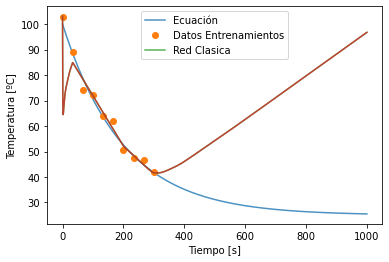

In [19]:
predsreg = net.predict(times)

preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(['Ecuación', 'Datos Entrenamientos','Red Clasica'])
plt.ylabel('Temperatura [ºC]')
plt.xlabel('Tiempo [s]')
plt.show()

se observa que el modelo aprende demasiado bien a adaptarse a los datos, sin embargo es malo generalizando, lo cual puede indicar overfitting, sin embargo al probar menos epocas este problema no desaparece;
es simplemente que el modelo no posee la información suficiente para generalizar en tiempos superiores.

Introdujendo la perdida con la ODE:

$$
0 = - R (T - T_{env}) - \frac{dT}{dt}
$$

In [21]:
def physics_loss(model: torch.nn.Module):

    # generamos un espacio de tiempo
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)

    dT_dt = grad(temps, ts)[0] # derivadas de temperaturas con respecto a varios tiempos
    # entonces procede a generar una PDE que desea cumplir, esta PDE esta igualada a 0
    pde_eq0 = - R*(temps - Tenv) - dT_dt 
    
    return torch.mean(pde_eq0**2)

Epoch 0/10000, loss: 4525.97
Epoch 1000/10000, loss: 2532.67
Epoch 2000/10000, loss: 2476.42
Epoch 3000/10000, loss: 2340.73
Epoch 4000/10000, loss: 1701.22
Epoch 5000/10000, loss: 693.63
Epoch 6000/10000, loss: 87.48
Epoch 7000/10000, loss: 9.37
Epoch 8000/10000, loss: 6.17
Epoch 9000/10000, loss: 5.75


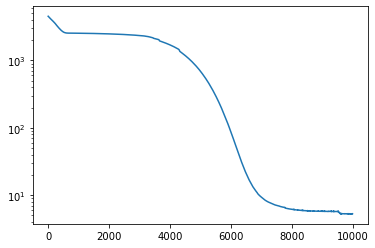

In [22]:
# input 1 salida 1, pero con 3 hidden layers

pinn = Net(1,1, loss2=physics_loss, epochs=10000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = pinn.fit(t, T)
plt.plot(losses)
plt.yscale('log')

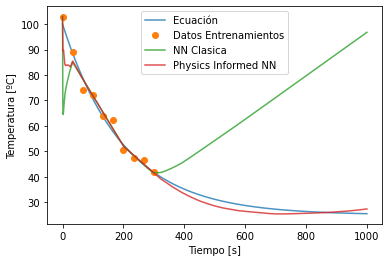

In [23]:
# predicción de la red
preds_pinn = pinn.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o') # datos reales
plt.plot(times, preds, alpha=0.8)
plt.plot(times, preds_pinn, alpha=0.8)

plt.legend(['Ecuación', 'Datos Entrenamientos','NN Clasica', 'Physics Informed NN'])
plt.ylabel('Temperatura [ºC]')
plt.xlabel('Tiempo [s]')
plt.show()

Tambien es posible usarlas para aprender sobre parametros desconocidos de una ecuación diferencial
agregandole al modelo un parametro entrenable

usando progamación orientada a objetos es tan facil como crear una clase hija y que herede todos los metodos del padre

In [24]:
class Net_Parametric(Net):
    def __init__( self,
        input_dim, output_dim, n_units=100, epochs=1000,
        loss=nn.MSELoss(), lr=1e-3, loss2=None, loss2_weight=0.1) -> None:

        # hereda todo el init del padre
        super().__init__(
            input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight
        )

        self.R = nn.Parameter(data=torch.tensor([0.])) # tensor de 0D

In [25]:
# esta función de perdida usa la la .R del modelo

def physics_loss_parametric(model: torch.nn.Module):

    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)

    dT_dt = grad(temps, ts)[0]

    pde_eq0 = - model.R*(temps - Tenv) - dT_dt 
    
    return torch.mean(pde_eq0**2)

Epoch 0/30000, loss: 4881.23
Epoch 3000/30000, loss: 2524.34
Epoch 6000/30000, loss: 2429.26
Epoch 9000/30000, loss: 1800.59
Epoch 12000/30000, loss: 358.32
Epoch 15000/30000, loss: 10.20
Epoch 18000/30000, loss: 3.20
Epoch 21000/30000, loss: 2.97
Epoch 24000/30000, loss: 2.84
Epoch 27000/30000, loss: 2.69


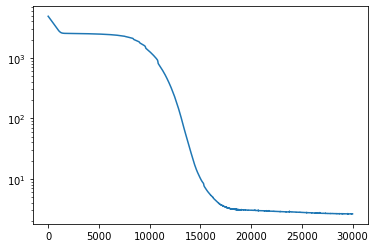

In [30]:
pinn_parametric = Net_Parametric(1, 1, loss2=physics_loss_parametric, 
    loss2_weight=1, epochs=30000, lr= 1e-5).to(DEVICE)

losses = pinn_parametric.fit(t, T)
plt.plot(losses)
plt.yscale('log')

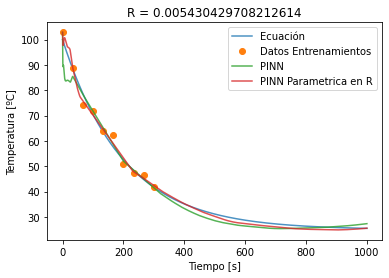

In [31]:
# predicción de la red
preds_pinn_parametric = pinn_parametric.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o') # datos reales
plt.plot(times, preds_pinn, alpha=0.8)
plt.plot(times, preds_pinn_parametric, alpha=0.8)


plt.legend(['Ecuación', 'Datos Entrenamientos','PINN', 'PINN Parametrica en R'])
plt.ylabel('Temperatura [ºC]')
plt.xlabel('Tiempo [s]')
plt.title(f'R = {pinn_parametric.R[0]}')
plt.show()

# Referencias
en donde se basa la idea del presente codigo

[1] Wolf, T. (2023, April 13). Physics-informed Neural Networks: a simple tutorial with PyTorch. Medium; Medium. https://medium.com/@theo.wolf/physics-informed-neural-networks-a-simple-tutorial-with-pytorch-f28a890b874a

excelente post para entender la teoria tras esto

[2] Henderson, I. (2022, October 24). Physics Informed Neural Networks (PINNs): An Intuitive Guide. Medium; Towards Data Science. https://towardsdatascience.com/physics-informed-neural-networks-pinns-an-intuitive-guide-fff138069563

[3] Maziar Raissi, Paris Perdikaris, and George Em Karniadakis, Physics Informed Deep Learning, https://maziarraissi.github.io/PINNs/

‌[4] Krishnapriyan, A. S. Characterizing possible failure modes in physics-informed neural networks, NeurIPS 2021, https://arxiv.org/abs/2109.01050

[5] PyTorch, Computational graphs, https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/